In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

sns.set_context('paper')
sns.color_palette('muted')
sns.set_style('whitegrid')
%matplotlib inline

# Import data

In [107]:
# Import track-level API data
trk = pd.read_json('../data/track_df.json')

# Make explicit column headers to avoid confusion when we merge with playlist track
trk = trk.rename(columns = {'name':'trk_name', 'id':'trk_id', 
                            'playlist_id':'pl_id', 'artist':'art_name', 
                            'popularity':'trk_popularity', 'added_at':'trk_added_at',
                           'duration':'trk_duration'})

print(trk.dtypes)
trk.head(10)

trk_added_at      datetime64[ns]
art_name                  object
trk_duration             float64
explicit                 float64
trk_id                    object
trk_name                  object
pl_id                     object
trk_popularity           float64
dtype: object


,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity
0,2013-09-30 16:12:24,Allgott & Villgott,119907.0,0.0,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0
1,2013-10-05 15:22:13,Allgott & Villgott,67918.0,0.0,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0
10,2014-07-16 13:50:24,J Boog,217270.0,0.0,4RjHalDdUreXDJSJLo44lK,Sunshine Girl,35XFuuqgCvTYQARix7CFpm,53.0
100,2014-07-06 09:12:01,Brennan Heart,222919.0,0.0,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0
1000,2012-06-29 11:53:52,Johnny Ray,153375.0,0.0,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0
10000,2016-10-19 08:47:35,Hurula,220929.0,0.0,69UN0GDw1dvmE3YxGJ0HUy,Helvete här,5xL1c6RCMhVDTVLZUsY5SR,41.0
100000,2014-08-04 16:09:48,Becky G,206166.0,0.0,3DmW6y7wTEYHJZlLo1r6XJ,Shower,5BASWniNjjZADnD9i96L45,70.0
100001,2013-08-03 17:10:52,Elton John,290680.0,0.0,1DqMnZpdOXy4mjmsXnFv2t,Circle Of Life,6uSxJmUwlS3RqjGEA0TRq8,4.0
100002,2013-09-10 14:11:36,Daniel Adams-Ray,231013.0,0.0,1qIAqSCPcRkkNU8dj5pIOC,Gubben i lådan,6Y81KUgVKTPUYHO05A2Sqr,53.0
100003,2017-08-20 10:53:49,Tony! Toni! Toné!,241466.0,0.0,0HsTJZWuj9vY7Ns0If1ARm,If I Had No Loot,0mEm0SZ7WsnI3w8ycnO6ue,37.0


In [108]:
# Import playlist-level API data
pl = pd.read_json('../data/plist_df.json')

# Make explicit column headers to avoid confusion when we merge with playlist track
pl = pl.rename(columns = {'name':'pl_name', 'id':'pl_id', 'followers':'pl_followers', 
                          'num_tracks':'pl_num_trks', 'user':'pl_owner',
                         'desc':'pl_desc'})

print(pl.dtypes)
pl.head(10)

collab             bool
pl_desc          object
pl_followers    float64
pl_id            object
pl_name          object
pl_num_trks       int64
pl_owner         object
dtype: object


,collab,pl_desc,pl_followers,pl_id,pl_name,pl_num_trks,pl_owner
0,False,None,2.0,3ftsSOkyCsILZeAZYQr2jH,Allgott o villgott,6,ellenholstad
1,False,None,0.0,27NLrsj0rlUi9S9Buj7NEl,Emelie och Nelli,9,ellenholstad
10,False,None,9.0,2DVuNt17JxlUUwP8VbjYMZ,Dame mas chocolinas,54,maka_97
100,False,None,22.0,07nCTAAPUQl3O9835StlnA,Miami Morty 💎🍭💸💘,46,thefamousnobody
1000,False,None,0.0,2nLFBeJkALxMcmYHqOnBAE,Michael Bublé – Call Me Irresponsible,13,vimmel76
1001,False,None,4.0,3kCN0aICbIUs7RjgVK00s6,Mornings with Angel,58,1177637361
1002,False,None,0.0,6xIePScn5oFe1XC1XZMRpm,One Direction — Olivia,3,blake.binns
1003,False,None,0.0,7H9SO2xfI394iVQLNXvO63,svensksommar,79,vimmel76
1004,False,None,0.0,2wHiKFc66l2W05tO2iBNMe,rosario,40,vimmel76
1005,False,None,0.0,1HA2U1AKqHBjDT7DcCHlqR,rosa passos,115,vimmel76


# Data wrangling - Spotify set

Before we import any external data sets, let's add some relevant data features that are inherit in the trk and pl dataframes:

# Master Dataset Build

In [109]:
# First, merge the two source datasets (one from track data API, one from playlist data API)  
df_trk = pd.merge(left = trk, right = pl, on = 'pl_id', how = 'left').dropna(subset = ['pl_followers'])
print("Master DF has total of {0} rows (including zero followers)".format(df_trk.shape[0]))

# Cut out the zero- and one- follower playlists
# Cutting one-follower playlists because it's likely just an individual following their own list
df_trk = df_trk[df_trk['pl_followers'] > 1]
print("Master DF has total of {0} rows (after removing zero followers) \n".format(df_trk.shape[0]))

print(df_trk.dtypes)
df_trk.head(10)

Master DF has total of 367916 rows (including zero followers)
Master DF has total of 210802 rows (after removing zero followers) 

trk_added_at      datetime64[ns]
art_name                  object
trk_duration             float64
explicit                 float64
trk_id                    object
trk_name                  object
pl_id                     object
trk_popularity           float64
collab                      bool
pl_desc                   object
pl_followers             float64
pl_name                   object
pl_num_trks                int64
pl_owner                  object
dtype: object


,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity,collab,pl_desc,pl_followers,pl_name,pl_num_trks,pl_owner
0,2013-09-30 16:12:24,Allgott & Villgott,119907.0,0.0,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0,False,None,2.0,Allgott o villgott,6,ellenholstad
1,2013-10-05 15:22:13,Allgott & Villgott,67918.0,0.0,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0,False,None,2.0,Allgott o villgott,6,ellenholstad
3,2014-07-06 09:12:01,Brennan Heart,222919.0,0.0,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0,False,None,1921.0,Ηardstyle♬ WORLD OF HARDSTYLE | Wildstylez | N...,282,denniswolf1992
4,2012-06-29 11:53:52,Johnny Ray,153375.0,0.0,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0,False,None,12.0,50's Jukebox Hits,329,1121819432
5,2016-10-19 08:47:35,Hurula,220929.0,0.0,69UN0GDw1dvmE3YxGJ0HUy,Helvete här,5xL1c6RCMhVDTVLZUsY5SR,41.0,False,Tina Mehrafzoon leder dig genom allt nytt av v...,987.0,Tina Mehrafzoon - Favoriter,264,p3_sverigesradio
6,2014-08-04 16:09:48,Becky G,206166.0,0.0,3DmW6y7wTEYHJZlLo1r6XJ,Shower,5BASWniNjjZADnD9i96L45,70.0,False,None,43.0,LIL'BITCH,26,thomasaunier
9,2017-08-20 10:53:49,Tony! Toni! Toné!,241466.0,0.0,0HsTJZWuj9vY7Ns0If1ARm,If I Had No Loot,0mEm0SZ7WsnI3w8ycnO6ue,37.0,False,All the hits that all Batang &#x27;90s loved l...,7.0,The Fantastic '90s,127,1177637361
10,2017-10-17 10:52:54,CNCO,205520.0,0.0,209gZgcfLq2aUuu51vOWBl,Hey DJ,66WFalGuFXfed3D87cFGzA,86.0,False,"Reggaeton 2017 con temas como Becky G, Bad Bun...",46335.0,A mi me gustan mayores,65,pacificspain
11,2014-08-19 21:34:47,Meghan Trainor,188754.0,0.0,0ifSeVGUr7py5GggttDhXw,All About That Bass,5BASWniNjjZADnD9i96L45,68.0,False,None,43.0,LIL'BITCH,26,thomasaunier
12,2014-08-04 15:58:11,Princess Superstar,215604.0,1.0,2tvR9Gi4UGJiDmVcpAagKK,Chick Habit,5BASWniNjjZADnD9i96L45,11.0,False,None,43.0,LIL'BITCH,26,thomasaunier


In [110]:
# NOTE THIS CELL COULD TAKE A FEW MINUTES TO RUN

# Data scrubbing
# Some popularity numbers are NaN.  We also have one null follower count.  Remove them.
df_trk = df_trk.dropna(subset = ['trk_popularity', 'pl_followers'])

# Data wrangling - additional track-level and playlist-level features

# Oldest and newest date that a track was added to the playlist
df_trk['pl_first_date'] = df_trk.groupby('pl_id')['trk_added_at'].transform('min')
df_trk['pl_last_date'] = df_trk.groupby('pl_id')['trk_added_at'].transform('max')
df_trk['pl_days_active'] = (df_trk['pl_last_date'] - df_trk['pl_first_date']).astype('timedelta64[D]')
df_trk['pl_days_old'] = (datetime.datetime.now() - df_trk['pl_first_date']).astype('timedelta64[D]')

# Number of tracks in the playlist
df_trk['pl_num_trk'] = df_trk.groupby('pl_id')['trk_id'].transform('count')

# Number of artists in the playlist
df_trk['pl_num_art'] = df_trk.groupby('pl_id')['art_name'].transform('nunique')

# Max, min, and average track popularity (by playlist)
df_trk['pl_min_trkpop'] = df_trk.groupby('pl_id')['trk_popularity'].transform('min')
df_trk['pl_max_trkpop'] = df_trk.groupby('pl_id')['trk_popularity'].transform('max')
df_trk['pl_mean_trkpop'] = df_trk.groupby('pl_id')['trk_popularity'].transform('mean')

df_trk['art_min_trkpop'] = df_trk.groupby('art_name')['trk_popularity'].transform('min')
df_trk['art_max_trkpop'] = df_trk.groupby('art_name')['trk_popularity'].transform('max')
df_trk['art_mean_trkpop'] = df_trk.groupby('art_name')['trk_popularity'].transform('mean')
df_trk['art_total_trks'] = df_trk.groupby('art_name')['trk_name'].transform('nunique').astype('int')

# Add a label category for each artist (currently just 5 labels but could be expanded)
df_trk['art_class'] = ""
df_trk.loc[(df_trk.art_mean_trkpop>=50) & (df_trk.art_total_trks>=10), 'art_class'] = 'superstar'
df_trk.loc[(df_trk.art_mean_trkpop>=20) & (df_trk.art_mean_trkpop<50) & (df_trk.art_total_trks>=10), 'art_class'] = 'star'
df_trk.loc[(df_trk.art_mean_trkpop>=0) & (df_trk.art_mean_trkpop<20) & (df_trk.art_total_trks>=10), 'art_class'] = 'crap_factory'
df_trk.loc[(df_trk.art_mean_trkpop>=40) & (df_trk.art_total_trks<10), 'art_class'] = 'one_hit_wonder'
df_trk.loc[(df_trk.art_mean_trkpop<40) & (df_trk.art_total_trks<10), 'art_class'] = 'garage_band'
df_trk['art_class'] = pd.Categorical(df_trk['art_class'], categories=["superstar","star","crap_factory", "one_hit_wonder", "garage_band"])

# Fix followers to int
df_trk['pl_followers'] = df_trk.loc[:,'pl_followers'].astype('int')

# Number of playlists per user
df_trk['user_pls_in_sample'] = df_trk.groupby('pl_owner')['pl_id'].transform('count')

# Size number of characters in the playlist description
df_trk['pl_desc_chars'] = df_trk.pl_desc.str.len().fillna(0).astype('int')

# Let's look at our new master dataset!
print(df_trk.dtypes)
df_trk.head(10)

trk_added_at          datetime64[ns]
art_name                      object
trk_duration                 float64
explicit                     float64
trk_id                        object
trk_name                      object
pl_id                         object
trk_popularity               float64
collab                          bool
pl_desc                       object
pl_followers                   int32
pl_name                       object
pl_num_trks                    int64
pl_owner                      object
pl_first_date         datetime64[ns]
pl_last_date          datetime64[ns]
pl_days_active               float64
pl_days_old                  float64
pl_num_trk                     int64
pl_num_art                     int64
pl_min_trkpop                float64
pl_max_trkpop                float64
pl_mean_trkpop               float64
art_min_trkpop               float64
art_max_trkpop               float64
art_mean_trkpop              float64
art_total_trks                 int32
a

,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity,collab,pl_desc,...,pl_min_trkpop,pl_max_trkpop,pl_mean_trkpop,art_min_trkpop,art_max_trkpop,art_mean_trkpop,art_total_trks,art_class,user_pls_in_sample,pl_desc_chars
0,2013-09-30 16:12:24,Allgott & Villgott,119907.0,0.0,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0,False,None,...,0.0,4.0,1.333333,0.0,4.0,1.333333,6,garage_band,32,0
1,2013-10-05 15:22:13,Allgott & Villgott,67918.0,0.0,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0,False,None,...,0.0,4.0,1.333333,0.0,4.0,1.333333,6,garage_band,32,0
3,2014-07-06 09:12:01,Brennan Heart,222919.0,0.0,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0,False,None,...,0.0,58.0,15.510000,0.0,47.0,12.250000,18,crap_factory,140,0
4,2012-06-29 11:53:52,Johnny Ray,153375.0,0.0,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0,False,None,...,0.0,0.0,0.000000,0.0,0.0,0.000000,1,garage_band,738,0
5,2016-10-19 08:47:35,Hurula,220929.0,0.0,69UN0GDw1dvmE3YxGJ0HUy,Helvete här,5xL1c6RCMhVDTVLZUsY5SR,41.0,False,Tina Mehrafzoon leder dig genom allt nytt av v...,...,0.0,71.0,32.370000,41.0,41.0,41.000000,1,one_hit_wonder,1537,294
6,2014-08-04 16:09:48,Becky G,206166.0,0.0,3DmW6y7wTEYHJZlLo1r6XJ,Shower,5BASWniNjjZADnD9i96L45,70.0,False,None,...,0.0,72.0,35.769231,49.0,91.0,79.946667,10,superstar,698,0
9,2017-08-20 10:53:49,Tony! Toni! Toné!,241466.0,0.0,0HsTJZWuj9vY7Ns0If1ARm,If I Had No Loot,0mEm0SZ7WsnI3w8ycnO6ue,37.0,False,All the hits that all Batang &#x27;90s loved l...,...,7.0,78.0,51.510000,34.0,56.0,48.142857,6,one_hit_wonder,1387,73
10,2017-10-17 10:52:54,CNCO,205520.0,0.0,209gZgcfLq2aUuu51vOWBl,Hey DJ,66WFalGuFXfed3D87cFGzA,86.0,False,"Reggaeton 2017 con temas como Becky G, Bad Bun...",...,0.0,97.0,61.692308,3.0,89.0,78.802395,20,superstar,1155,271
11,2014-08-19 21:34:47,Meghan Trainor,188754.0,0.0,0ifSeVGUr7py5GggttDhXw,All About That Bass,5BASWniNjjZADnD9i96L45,68.0,False,None,...,0.0,72.0,35.769231,3.0,79.0,56.045455,12,superstar,698,0
12,2014-08-04 15:58:11,Princess Superstar,215604.0,1.0,2tvR9Gi4UGJiDmVcpAagKK,Chick Habit,5BASWniNjjZADnD9i96L45,11.0,False,None,...,0.0,72.0,35.769231,0.0,11.0,2.750000,3,garage_band,698,0


# Playlist-level dataset build

In [111]:
# Make a playlist data subset as we'll use this often for EDA.  

df_pl_columns = ['pl_id', 'pl_days_old', 
                 'pl_days_active', 'pl_num_trk', 'pl_num_art', 
                 'pl_min_trkpop', 'pl_max_trkpop', 'pl_mean_trkpop', 
                 'pl_followers', 'pl_num_trks','pl_desc_chars'] 

df_pl = df_trk.groupby('pl_id').first().reset_index()[df_pl_columns]

print(df_pl.dtypes)
df_pl.head(10)

pl_id              object
pl_days_old       float64
pl_days_active    float64
pl_num_trk          int64
pl_num_art          int64
pl_min_trkpop     float64
pl_max_trkpop     float64
pl_mean_trkpop    float64
pl_followers        int32
pl_num_trks         int64
pl_desc_chars       int32
dtype: object


,pl_id,pl_days_old,pl_days_active,pl_num_trk,pl_num_art,pl_min_trkpop,pl_max_trkpop,pl_mean_trkpop,pl_followers,pl_num_trks,pl_desc_chars
0,002LPUZEpvopnQuRsxLjyV,1042.0,0.0,42,38,0.0,69.0,18.071429,2,42,0
1,009Uzz7eRh7QAIoeAKd0XN,739.0,0.0,26,25,0.0,61.0,21.615385,5514,26,13
2,00e2vXzWaSmxJ1Fga6l2ug,39.0,34.0,100,68,1.0,83.0,49.520000,209486,144,92
3,00tBWkHg7g57IiIaqkTeYa,1143.0,130.0,70,51,0.0,73.0,40.228571,5,70,0
4,01RvEaL25Hr46erZckIOlp,1672.0,1212.0,100,38,0.0,80.0,42.570000,8,132,0
5,01RxbAsOSE0Aul4EKZQmN8,510.0,326.0,11,5,2.0,41.0,17.909091,8,11,0
6,01ZJ1fP7U7BwFoMUalCMl3,818.0,66.0,100,28,0.0,70.0,35.500000,4,101,0
7,01ce8cS6l2s280pGIOZBQU,164.0,3.0,100,72,12.0,85.0,61.690000,6,100,0
8,01omoXtdppulQ4w7zn7R3Q,1200.0,0.0,15,2,0.0,0.0,0.000000,344,15,0
9,01rjgzyfJG0tsaZZDctx6z,565.0,529.0,100,35,0.0,78.0,52.880000,243,138,0


# Now let's get our EDA ON BABY

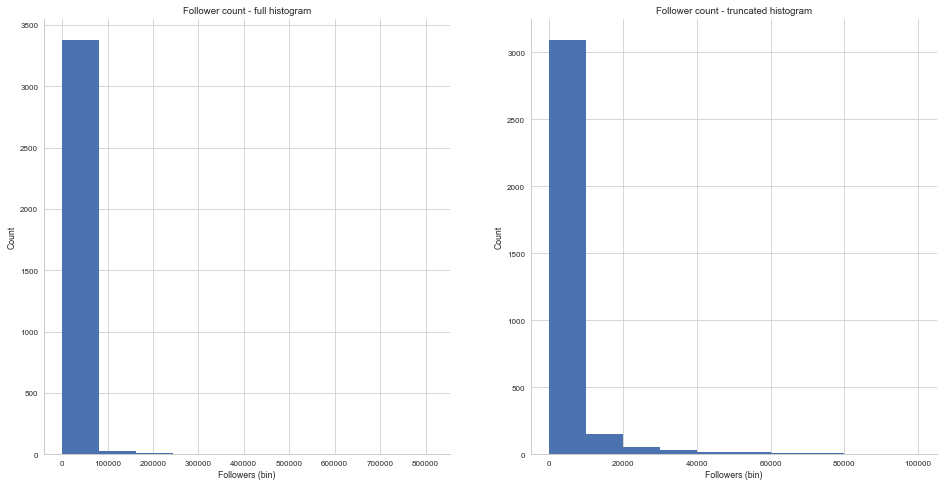

In [112]:
# Plot histogram of follower counts for each playlist
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].hist(df_pl.pl_followers)
ax[0].set_title("Follower count - full histogram")
ax[0].set_xlabel("Followers (bin)")
ax[0].set_ylabel("Count")
sns.despine()

ax[1].hist(df_pl.pl_followers, range = (0,100000))
ax[1].set_title("Follower count - truncated histogram")
ax[1].set_xlabel("Followers (bin)")
ax[1].set_ylabel("Count")
sns.despine(top = True, right = True)

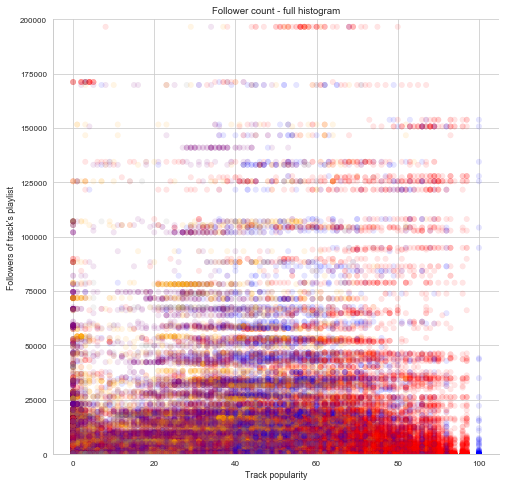

In [122]:
# Plot follower count vs. average track popularity
fig, ax = plt.subplots(1,1, figsize = (8,8))

colors = {'superstar':'red', 'star':'orange', 'crap_factory':'grey', 'one_hit_wonder':'blue', 'garage_band':'purple'}

ax.scatter(df_trk['trk_popularity'], df_trk['pl_followers'], alpha = 0.1, c=df_trk['art_class'].apply(lambda x: colors[x]))
ax.set_title("Follower count - full histogram")
ax.set_xlabel("Track popularity")
ax.set_ylabel("Followers of track's playlist")
ax.set_ylim((0,200000))
sns.despine(top = True, right = True)

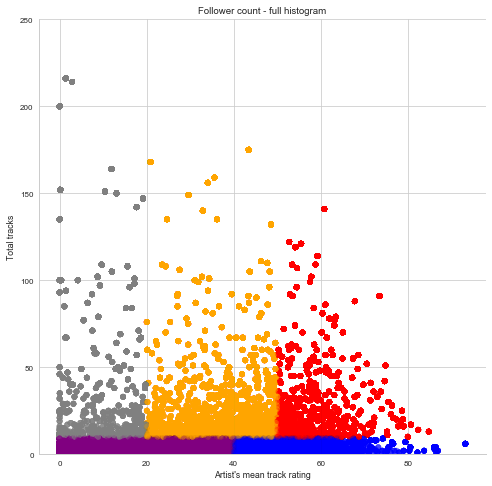

In [114]:
# Plot follower count vs. average track popularity
fig, ax = plt.subplots(1,1, figsize = (8,8))

colors = {'superstar':'red', 'star':'orange', 'crap_factory':'grey', 'one_hit_wonder':'blue', 'garage_band':'purple'}

ax.scatter(df_trk.art_mean_trkpop, df_trk.art_total_trks, alpha = 0.1, c=df_trk['art_class'].apply(lambda x: colors[x]))
ax.set_title("Follower count - full histogram")
ax.set_xlabel("Artist's mean track rating")
ax.set_ylabel("Total tracks")
plt.ylim((0,250))
sns.despine(top = True, right = True)

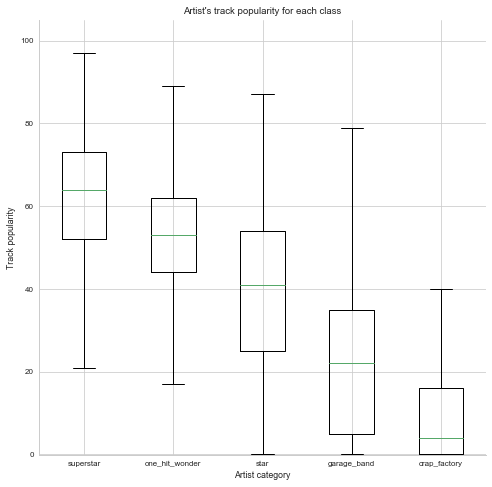

In [147]:
# Plot follower count vs. average track popularity
fig, ax = plt.subplots(1,1, figsize = (8,8))

labels = ['superstar', 'one_hit_wonder', 'star', 'garage_band', 'crap_factory']

ax.boxplot([df_trk[df_trk.art_class == 'superstar'].trk_popularity.values,
            df_trk[df_trk.art_class == 'one_hit_wonder'].trk_popularity.values,
            df_trk[df_trk.art_class == 'star'].trk_popularity.values,
            df_trk[df_trk.art_class == 'garage_band'].trk_popularity.values,
            df_trk[df_trk.art_class == 'crap_factory'].trk_popularity.values], labels = labels)
ax.set_title("Artist's track popularity for each class")
ax.set_xlabel("Artist category")
ax.set_ylabel("Track popularity")
ax.set_ylim((-0.1, 105))
sns.despine(top = True, right = True)

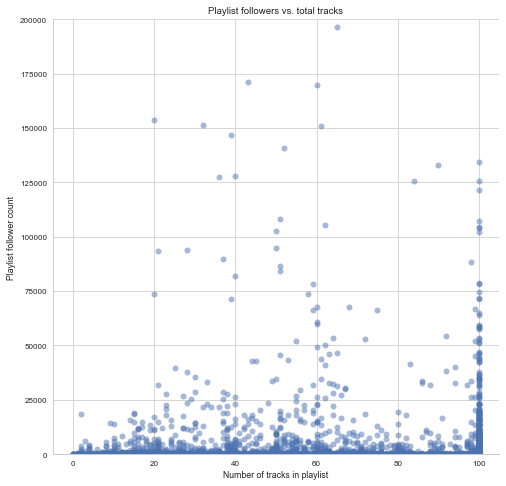

In [115]:
# Test if bigger playlists have more followers
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(df_pl.pl_num_trk, df_pl.pl_followers, alpha = 0.5)
ax.set_title("Playlist followers vs. total tracks")
ax.set_xlabel("Number of tracks in playlist")
ax.set_ylabel("Playlist follower count")
ax.set_ylim((0,200000))
sns.despine(top = True, right = True)

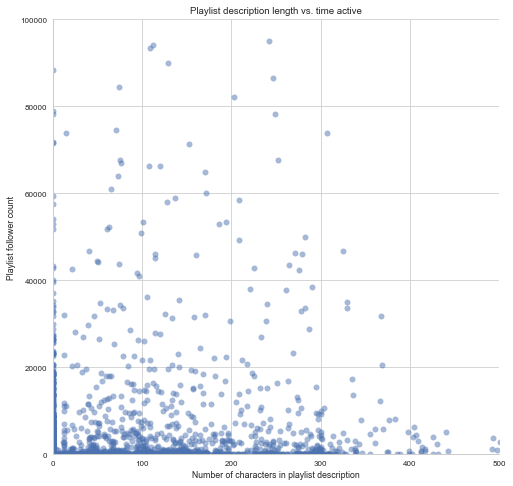

In [116]:
# Test if playlists with longer descriptions have more followers
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(df_pl.pl_desc_chars, df_pl.pl_followers, alpha = 0.5)
ax.set_title("Playlist description length vs. time active")
ax.set_xlabel("Number of characters in playlist description")
ax.set_ylabel("Playlist follower count")
ax.set_ylim((0,100000))
ax.set_xlim((0,500))
sns.despine(top = True, right = True)

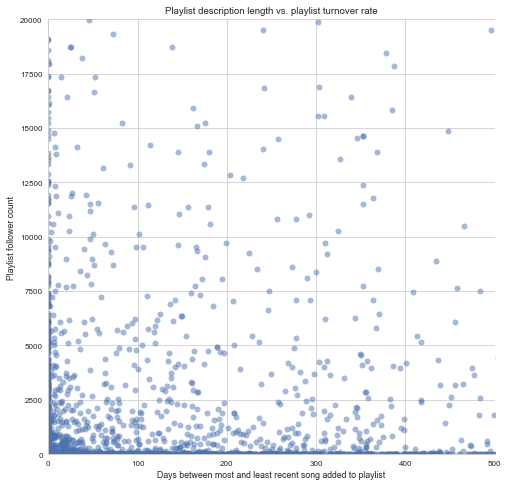

In [117]:
# Test if playlists with longer activity have more followers
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(df_pl.pl_days_active, df_pl.pl_followers, alpha = 0.5)
ax.set_title("Playlist description length vs. playlist turnover rate")
ax.set_xlabel("Days between most and least recent song added to playlist")
ax.set_ylabel("Playlist follower count")
ax.set_ylim((0,20000))
ax.set_xlim((0,500))
sns.despine(top = True, right = True)

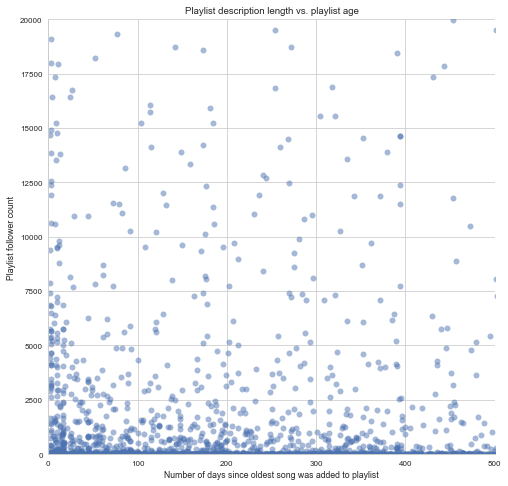

In [118]:
# Test if playlists with longer activity have more followers
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(df_pl.pl_days_old, df_pl.pl_followers, alpha = 0.5)
ax.set_title("Playlist description length vs. playlist age")
ax.set_xlabel("Number of days since oldest song was added to playlist")
ax.set_ylabel("Playlist follower count")
ax.set_ylim((0,20000))
ax.set_xlim((0,500))
sns.despine(top = True, right = True)

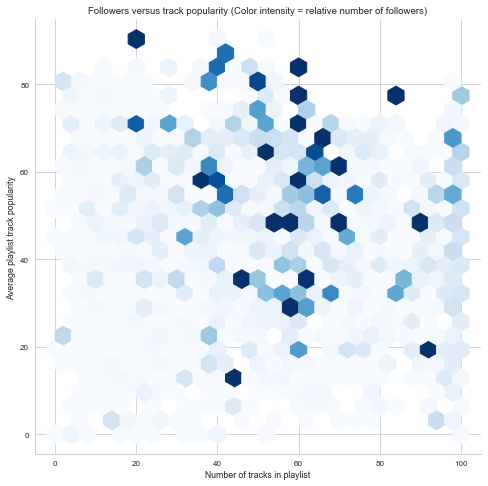

In [119]:
# Test playlist mean/max popularity versus follower count
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.hexbin(df_pl.pl_num_trk, df_pl.pl_mean_trkpop, C=df_pl.pl_followers, cmap='Blues', gridsize = 25, vmax=35000)
ax.set_title("Followers versus track popularity (Color intensity = relative number of followers)")
ax.set_xlabel("Number of tracks in playlist")
ax.set_ylabel("Average playlist track popularity")
sns.despine(top = True, right = True)

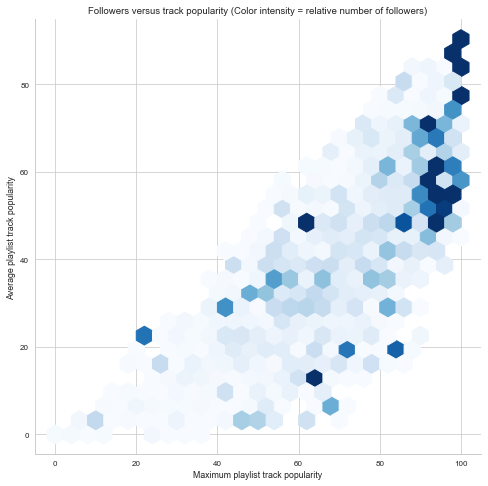

In [120]:
# Test playlist mean/max popularity versus follower count
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.hexbin(df_pl.pl_max_trkpop, df_pl.pl_mean_trkpop, C=df_pl.pl_followers, cmap='Blues', gridsize = 25, vmax=25000)
ax.set_title("Followers versus track popularity (Color intensity = relative number of followers)")
ax.set_xlabel("Maximum playlist track popularity")
ax.set_ylabel("Average playlist track popularity")
sns.despine(top = True, right = True)